Deep Learning using Rectified Linear Units
===

## Overview

In this notebook, we explore the performance of a neural net with varying activation functions on an image classification task.

We load our dependencies.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__version__ = '1.0.0'
__author__ = 'Abien Fred Agarap'

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

We set up the GPU memory growth.

In [2]:
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

We set the random seeds for reproducibility.

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

We set the batch size, the number of epochs, and the number of units per layer.

In [4]:
batch_size = 256
epochs = 300
neurons = [512, 512]

## Data Preparation

We load the MNIST dataset.

In [5]:
(train_features, train_labels), (test_features, test_labels) = tf.keras.datasets.mnist.load_data()

We scale the images.

In [6]:
train_features = train_features.astype('float32').reshape(-1, 784) / 255.
test_features = test_features.astype('float32').reshape(-1, 784) / 255.

We one-hot encode labels.

In [7]:
train_labels = tf.one_hot(train_labels, 10)
test_labels = tf.one_hot(test_labels, 10)

We create a `tf.data.Dataset` object for the training dataset.

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
dataset = dataset.prefetch(4096).shuffle(4096).batch(batch_size, True)

## Model

We write a `NeuralNet` class that consists of two hidden layers.

In [9]:
class NeuralNet(tf.keras.Model):
    def __init__(self, **kwargs):
        super(NeuralNet, self).__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(
            units=kwargs['units'][0],
            activation=kwargs['activation'],
            kernel_initializer=kwargs['initializer']
        )
        self.hidden_layer_2 = tf.keras.layers.Dense(
            units=kwargs['units'][1],
            activation=kwargs['activation'],
            kernel_initializer=kwargs['initializer']
        )
        self.output_layer = tf.keras.layers.Dense(units=kwargs['num_classes'])
        self.optimizer = tf.optimizers.SGD(learning_rate=3e-4, momentum=9e-1)
    
    @tf.function
    def call(self, features):
        activation = self.hidden_layer_1(features)
        activation = self.hidden_layer_2(activation)
        output = self.output_layer(activation)
        return output

We define our loss function.

In [10]:
def loss_fn(logits, labels):
    softmax_loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    return tf.reduce_mean(softmax_loss)

We define a function for a training step.

In [11]:
def train_step(model, loss, features, labels):
    with tf.GradientTape() as tape:
        logits = model(features)
        train_loss = loss(logits=logits, labels=labels)
    gradients = tape.gradient(train_loss, model.trainable_variables)
    model.optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return train_loss

We define a training function.

In [12]:
def train(model, loss_fn, dataset, epochs):
    epoch_accuracy = []
    epoch_loss = []
    for epoch in range(epochs):
        train_accuracy = []
        train_loss = 0
        for batch_features, batch_labels in dataset:
            batch_features += tf.random.normal(stddev=(1. / (1. + epoch)**0.55), shape=batch_features.shape)
            loss = train_step(model, loss_fn, batch_features, batch_labels)
            
            accuracy = tf.metrics.Accuracy()
            predictions = tf.nn.softmax(model(batch_features))
            accuracy(tf.argmax(predictions, 1), tf.argmax(batch_labels, 1))
            
            train_loss += loss
            train_accuracy.append(accuracy.result())
        
        epoch_loss.append(tf.reduce_mean(train_loss))
        epoch_accuracy.append(tf.reduce_mean(train_accuracy))
        
        if (epoch != 0) and ((epoch + 1) % 50 == 0):
            print('epoch {}/{} : mean loss = {}, mean accuracy = {}'.format(epoch + 1,
                                                                            epochs,
                                                                            tf.reduce_mean(train_loss),
                                                                            tf.reduce_mean(train_accuracy)))
    return epoch_accuracy, epoch_loss

### Logistic-based Model

We define a 2-layer NN with Logistic activation function.

In [13]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.sigmoid,
    initializer='glorot_uniform',
    num_classes=10
)

We train our model for 300 epochs.

In [14]:
logistic_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 255.48536682128906, mean accuracy = 0.7616519927978516
epoch 100/300 : mean loss = 133.155029296875, mean accuracy = 0.8528144955635071
epoch 150/300 : mean loss = 102.96658325195312, mean accuracy = 0.8795906901359558
epoch 200/300 : mean loss = 90.62866973876953, mean accuracy = 0.890808641910553
epoch 250/300 : mean loss = 83.97627258300781, mean accuracy = 0.8976863026618958
epoch 300/300 : mean loss = 79.65133666992188, mean accuracy = 0.9025607705116272


We produce predictions for the test data.

In [15]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [16]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [17]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9057000279426575


### TanH-based Model

We define a 2-layer NN with Hyperbolic Tangent activation function.

In [18]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.tanh,
    initializer='glorot_uniform',
    num_classes=10
)

We train our model for 300 epochs.

In [19]:
tanh_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 72.74628448486328, mean accuracy = 0.9097222089767456
epoch 100/300 : mean loss = 60.41146469116211, mean accuracy = 0.9266993999481201
epoch 150/300 : mean loss = 51.40932846069336, mean accuracy = 0.9381677508354187
epoch 200/300 : mean loss = 43.79719161987305, mean accuracy = 0.9476996660232544
epoch 250/300 : mean loss = 37.72518539428711, mean accuracy = 0.954543948173523
epoch 300/300 : mean loss = 32.769771575927734, mean accuracy = 0.9600861668586731


We produce predictions for the test data.

In [20]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [21]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [22]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9578999876976013


### ReLU-based Model

We define a 2-layer NN with ReLU activation function.

In [23]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.relu,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [24]:
relu_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 59.68490982055664, mean accuracy = 0.9267327785491943
epoch 100/300 : mean loss = 40.60714340209961, mean accuracy = 0.9511218070983887
epoch 150/300 : mean loss = 30.836206436157227, mean accuracy = 0.9627403616905212
epoch 200/300 : mean loss = 24.881916046142578, mean accuracy = 0.9702523946762085
epoch 250/300 : mean loss = 20.494564056396484, mean accuracy = 0.9753772616386414
epoch 300/300 : mean loss = 17.315397262573242, mean accuracy = 0.9797676205635071


We produce predictions for the test data.

In [25]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [26]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [27]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9735999703407288


### Leaky ReLU-based Model

We define a 2-layer NN with Leaky ReLU activation function.

In [28]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.leaky_relu,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [29]:
lrelu_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 62.70967483520508, mean accuracy = 0.9226095080375671
epoch 100/300 : mean loss = 44.980323791503906, mean accuracy = 0.945846676826477
epoch 150/300 : mean loss = 35.20400619506836, mean accuracy = 0.9576489329338074
epoch 200/300 : mean loss = 28.809045791625977, mean accuracy = 0.9662293195724487
epoch 250/300 : mean loss = 24.211057662963867, mean accuracy = 0.9711705446243286
epoch 300/300 : mean loss = 20.69866180419922, mean accuracy = 0.9753438830375671


We produce predictions for the test data.

In [30]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [31]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [32]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9697999954223633


### Softplus-based Model

We define a 2-layer NN with Softplus activation function.

In [33]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.softplus,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [34]:
softplus_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 77.94357299804688, mean accuracy = 0.9036625027656555
epoch 100/300 : mean loss = 67.4006118774414, mean accuracy = 0.9175513982772827
epoch 150/300 : mean loss = 61.62861251831055, mean accuracy = 0.9262486696243286
epoch 200/300 : mean loss = 56.37195587158203, mean accuracy = 0.93287593126297
epoch 250/300 : mean loss = 51.185768127441406, mean accuracy = 0.9392527937889099
epoch 300/300 : mean loss = 46.235389709472656, mean accuracy = 0.9446447491645813


We produce predictions for the test data.

In [35]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [36]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [37]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.9427000284194946


### ELU-based Model

We define a 2-layer NN with ELU activation function.

In [38]:
model = NeuralNet(
    units=neurons,
    activation=tf.nn.elu,
    initializer='he_normal',
    num_classes=10
)

We train our model for 300 epochs.

In [39]:
elu_performance = train(model, loss_fn, dataset, epochs=epochs)

epoch 50/300 : mean loss = 66.81639862060547, mean accuracy = 0.9182191491127014
epoch 100/300 : mean loss = 51.78060531616211, mean accuracy = 0.9379173517227173
epoch 150/300 : mean loss = 41.613834381103516, mean accuracy = 0.9501702785491943
epoch 200/300 : mean loss = 34.51963806152344, mean accuracy = 0.9582999348640442
epoch 250/300 : mean loss = 29.249319076538086, mean accuracy = 0.9649605751037598
epoch 300/300 : mean loss = 25.471235275268555, mean accuracy = 0.9700520634651184


We produce predictions for the test data.

In [40]:
predictions = tf.nn.softmax(model(test_features))

We compute the test accuracy.

In [41]:
accuracy = tf.metrics.Accuracy()
test_accuracy = accuracy(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))

Check for the test accuracy.

In [42]:
print('Test accuracy : {}'.format(test_accuracy.numpy()))

Test accuracy : 0.964900016784668


## Training Performance

We lay down the training performance of each model.

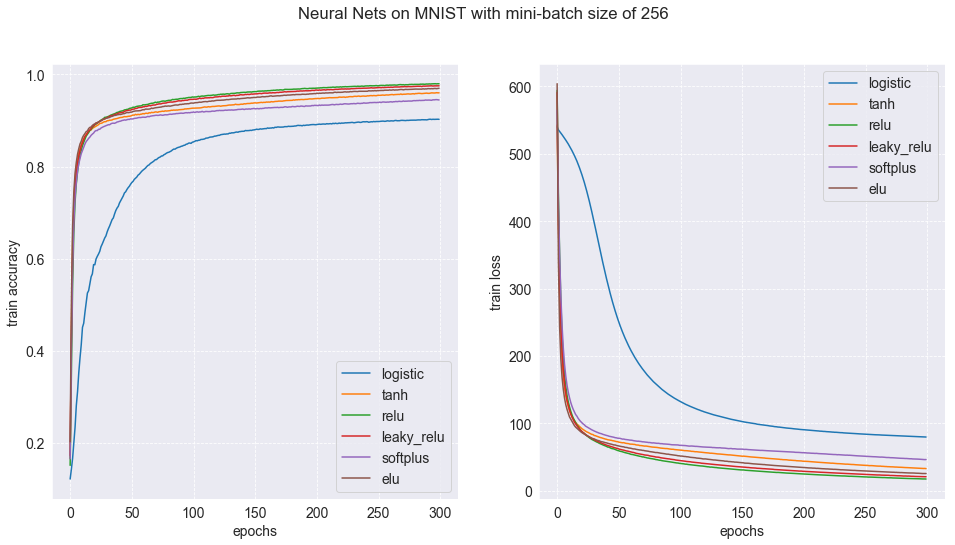

In [43]:
sns.set_style('dark', {'grid.linestyle': '--'})
plt.figure(figsize=(16, 8))
plt.rcParams.update({'font.size': 14})

plt.subplot(121)
plt.plot(range(len(logistic_performance[0])), logistic_performance[0], label='logistic')
plt.plot(range(len(tanh_performance[0])), tanh_performance[0], label='tanh')
plt.plot(range(len(relu_performance[0])), relu_performance[0], label='relu')
plt.plot(range(len(lrelu_performance[0])), lrelu_performance[0], label='leaky_relu')
plt.plot(range(len(softplus_performance[0])), softplus_performance[0], label='softplus')
plt.plot(range(len(elu_performance[0])), elu_performance[0], label='elu')
plt.xlabel('epochs')
plt.ylabel('train accuracy')
plt.legend(loc='lower right')
plt.grid()

plt.subplot(122)
plt.plot(range(len(logistic_performance[1])), logistic_performance[1], label='logistic')
plt.plot(range(len(tanh_performance[1])), tanh_performance[1], label='tanh')
plt.plot(range(len(relu_performance[1])), relu_performance[1], label='relu')
plt.plot(range(len(lrelu_performance[1])), lrelu_performance[1], label='leaky_relu')
plt.plot(range(len(softplus_performance[1])), softplus_performance[1], label='softplus')
plt.plot(range(len(elu_performance[1])), elu_performance[1], label='elu')
plt.xlabel('epochs')
plt.ylabel('train loss')
plt.legend(loc='upper right')
plt.grid()

plt.suptitle('Neural Nets on MNIST with mini-batch size of 256')
plt.savefig('mnist_experiments_256.png', dpi=300)
plt.show()